In [2]:
import sys
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

sys.path.append('..')
from src.transformers_ import *
from src.utils import handle_same_name_col, data_with_important_features
from src.stack_pipelines import make_union
from src.predictors import stacking_model_pipe, plot_weak_learners_feature_importance, cv_model

pd.set_option('display.max_columns', None)
random.seed(42)

In [ ]:
credits = pd.read_csv('../movies/tmdb_5000_credits.csv', index_col='movie_id')
movies = pd.read_csv('../movies/tmdb_5000_movies.csv', index_col='id')

data = pd.merge(movies, credits)
data.shape

In [3]:
data.head(2)

,budget,genres,homepage,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [4]:
data = data.loc[data['revenue'] != 0]
data['revenue'].dropna(inplace=True)
data.shape

(3379, 21)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['revenue'], axis=1), data['revenue']) 

In [6]:
exploratory = X_train.copy()

In [7]:
exploratory.shape

(2534, 20)

# 1. EDA & Data transformation


## 1.1 Checking missing values

In [8]:
nan_percent = exploratory.isna().mean()*100
nan_count = exploratory.isna().sum()
pd.concat([nan_count.rename('missing_count'), nan_percent.round().rename('missing_percent')], axis=1)

,missing_count,missing_percent
budget,0,0.0
genres,0,0.0
homepage,1490,59.0
keywords,0,0.0
original_language,0,0.0
original_title,0,0.0
overview,0,0.0
popularity,0,0.0
production_companies,0,0.0
production_countries,0,0.0


In [9]:
# TODO imputers? - adn. - gb trees handle NaN values

In [10]:
columns_to_drop = ['original_title', 'overview', 'tagline', 'title']
exploratory = exploratory.drop(columns_to_drop, axis=1)

In [11]:
exploratory.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2534 entries, 3643 to 2809
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                2534 non-null   int64  
 1   genres                2534 non-null   object 
 2   homepage              1044 non-null   object 
 3   keywords              2534 non-null   object 
 4   original_language     2534 non-null   object 
 5   popularity            2534 non-null   float64
 6   production_companies  2534 non-null   object 
 7   production_countries  2534 non-null   object 
 8   release_date          2534 non-null   object 
 9   runtime               2534 non-null   float64
 10  spoken_languages      2534 non-null   object 
 11  status                2534 non-null   object 
 12  vote_average          2534 non-null   float64
 13  vote_count            2534 non-null   int64  
 14  cast                  2534 non-null   object 
 15  crew                  2

-    ratio - it's a numerical scale with absolute zero, for example, age;
-    interval - it's also a numerical scale, but without absolute zero, as it is the case for Fahrenheit scale. For temperature measurement Kelvin would be a ratio scale;
-    ordinal - which is not present in our data set, refers to measurements you can put in order, but you cannot tell the quantitive difference between adjacent measurements;
-    nominal - in this scale each item is treated as having the same quality, for example, city names;

In [12]:
dtypes_description = pd.Series(['ratio', 'nominal', 'nominal', 'nominal', 'nominal', 'ratio', 'nominal', 'nominal', \
                     'interval', 'ratio', 'nominal', 'nominal', 'ratio', 'ratio', 'nominal', 'nominal'], \
                     index=exploratory.dtypes.index)
dtypes_description

budget                     ratio
genres                   nominal
homepage                 nominal
keywords                 nominal
original_language        nominal
popularity                 ratio
production_companies     nominal
production_countries     nominal
release_date            interval
runtime                    ratio
spoken_languages         nominal
status                   nominal
vote_average               ratio
vote_count                 ratio
cast                     nominal
crew                     nominal
dtype: object

In [13]:
pd.concat([exploratory.dtypes.rename('dtype'), exploratory.iloc[420].rename('example'), dtypes_description.rename('description')], axis=1)

,dtype,example,description
budget,int64,30000000,ratio
genres,object,"[{""id"": 28, ""name"": ""Action""}, {""id"": 18, ""nam...",nominal
homepage,object,NaN,nominal
keywords,object,"[{""id"": 6075, ""name"": ""sport""}]",nominal
original_language,object,en,nominal
popularity,float64,65.364452,ratio
production_companies,object,"[{""name"": ""Escape Artists"", ""id"": 1423}, {""nam...",nominal
production_countries,object,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",nominal
release_date,object,2015-06-15,interval
runtime,float64,123.0,ratio


In [14]:
exploratory.dtypes

budget                    int64
genres                   object
homepage                 object
keywords                 object
original_language        object
popularity              float64
production_companies     object
production_countries     object
release_date             object
runtime                 float64
spoken_languages         object
status                   object
vote_average            float64
vote_count                int64
cast                     object
crew                     object
dtype: object

## 1.2 Nominal data

### 1.2.1 Dummifying
For most of the data coming in the form of a list of dictionaries, we'll simply extract fields that interest us, and dummify them. In some cases, to avoid sparsification, we'll choose some fraction of the most occurring values.

Columns to dummify:

**genres, keywords, production_companies, production_countries, crew**

In [15]:
exploratory[['genres', 'spoken_languages', 'crew']].head()

,genres,spoken_languages,crew
3643,"[{""id"": 18, ""name"": ""Drama""}]","[{""iso_639_1"": ""en"", ""name"": ""English""}]","[{""credit_id"": ""58ea9e59c3a36872f6079e57"", ""de..."
3481,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 35, ""name...","[{""iso_639_1"": ""en"", ""name"": ""English""}]","[{""credit_id"": ""560274b192514122c30013fb"", ""de..."
5,"[{""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""na...","[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...","[{""credit_id"": ""52fe4252c3a36847f80151a5"", ""de..."
3792,"[{""id"": 80, ""name"": ""Crime""}, {""id"": 18, ""name...","[{""iso_639_1"": ""en"", ""name"": ""English""}]","[{""credit_id"": ""52fe475fc3a36847f81320fb"", ""de..."
800,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 28, ""name...","[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...","[{""credit_id"": ""53677d8c0e0a2647c4005769"", ""de..."


In [16]:
exploratory.genres.iloc[0]

'[{"id": 18, "name": "Drama"}]'

In [17]:
exploratory.crew.iloc[0][:300]

'[{"credit_id": "58ea9e59c3a36872f6079e57", "department": "Production", "gender": 1, "id": 2227, "job": "Producer", "name": "Nicole Kidman"}, {"credit_id": "52fe4556c3a368484e0544f9", "department": "Directing", "gender": 2, "id": 17114, "job": "Director", "name": "John Cameron Mitchell"}, {"credit_id'

In [18]:
exploratory.spoken_languages.iloc[1]

'[{"iso_639_1": "en", "name": "English"}]'

### 1.2.2 Binarization
Here we'll simple binarize the data - the column will get label True or False (or 1 or 0) on certain, established condition.

Columns to binarize:

**homepage, original_language, status, spoken_languages**

In [19]:
exploratory.original_language.unique()

array(['en', 'fr', 'fa', 'de', 'es', 'it', 'is', 'cn', 'ja', 'pt', 'hi',
       'zh', 'vi', 'ko', 'nb', 'ro', 'da', 'id', 'pl', 'th', 'xx', 'nl',
       'ru'], dtype=object)

In [20]:
exploratory.original_language.isna().sum()

0

In [21]:
exploratory.status.unique()

array(['Released', 'Post Production'], dtype=object)

In [22]:
exploratory.status.isna().sum()

0

In [23]:
exploratory[['homepage', 'original_language', 'status']].head()

,homepage,original_language,status
3643,http://www.rabbitholefilm.com/,en,Released
3481,NaN,en,Released
5,http://www.sonypictures.com/movies/spider-man3/,en,Released
3792,NaN,en,Released
800,http://www.redtails2012.com/,en,Released


### 1.2.3 Counts
As an example, we'll count how many popular actors (having most appearances) are cast in a movie. Perhaps the more of them playing in one movie, the higher is the revenue...

In [24]:
exploratory['cast'].head().to_frame()

,cast
3643,"[{""cast_id"": 3, ""character"": ""Becca Corbett"", ..."
3481,"[{""cast_id"": 1, ""character"": ""Vince Rizzo"", ""c..."
5,"[{""cast_id"": 30, ""character"": ""Peter Parker / ..."
3792,"[{""cast_id"": 2, ""character"": ""Burke / Forsythe..."
800,"[{""cast_id"": 2, ""character"": ""Colonel William ..."


In [25]:
exploratory.cast.iloc[0]

'[{"cast_id": 3, "character": "Becca Corbett", "credit_id": "52fe4556c3a368484e054503", "gender": 1, "id": 2227, "name": "Nicole Kidman", "order": 0}, {"cast_id": 7, "character": "Howie Corbett", "credit_id": "52fe4556c3a368484e05450f", "gender": 2, "id": 6383, "name": "Aaron Eckhart", "order": 1}, {"cast_id": 6, "character": "Nat", "credit_id": "52fe4556c3a368484e05450b", "gender": 1, "id": 1902, "name": "Dianne Wiest", "order": 2}, {"cast_id": 10, "character": "Jason", "credit_id": "52fe4556c3a368484e05451d", "gender": 2, "id": 996701, "name": "Miles Teller", "order": 3}, {"cast_id": 8, "character": "Izzy", "credit_id": "52fe4556c3a368484e054513", "gender": 1, "id": 16859, "name": "Tammy Blanchard", "order": 4}, {"cast_id": 5, "character": "Gabby", "credit_id": "52fe4556c3a368484e054507", "gender": 1, "id": 25540, "name": "Sandra Oh", "order": 5}, {"cast_id": 11, "character": "Auggie", "credit_id": "52fe4556c3a368484e054521", "gender": 2, "id": 4808, "name": "Giancarlo Esposito", "or

### 1.2.4. Date Extraction

In this data set, we have release_date in a string form. Probably it will be better if we extract from it: year, month and day, and dummify the latter two.


In [26]:
exploratory['release_date'].head().to_frame()

,release_date
3643,2010-12-16
3481,2009-03-06
5,2007-05-01
3792,1988-03-04
800,2012-01-19


## 1.3 Nominal Data Transformation
### 1.3.1 Feature selector
This transformer is really straightforward - it simply takes the name of the column we want to extract and if we use it, it will 'spit out' the data column of our Data Frame.

In [27]:
prod_companies = FeatureSelector('production_companies').fit_transform(exploratory)
prod_companies.to_frame().head()

,production_companies
3643,"[{""name"": ""Olympus Pictures"", ""id"": 7400}]"
3481,"[{""name"": ""Lucky Monkey Pictures"", ""id"": 11093..."
5,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam..."
3792,"[{""name"": ""Empire Pictures"", ""id"": 1212}]"
800,"[{""name"": ""Lucasfilm"", ""id"": 1}, {""name"": ""Twe..."


In [28]:
prod_companies.iloc[0]

'[{"name": "Olympus Pictures", "id": 7400}]'

### 1.3.2 Dictionary vectorizer
This one is a bit more complex. It's role is to:

- 1st - extract values from dictionaries,
- 2nd - join them in one string,
- 3rd - dummify it using sklearn Count Vectorizer.

In [29]:
prod_companies_vectorized = DictionaryVectorizer('name').fit_transform(prod_companies)
prod_companies_vectorized

100_bares  1019_entertainment  10th_hole_productions  120_films  \
3643          0                   0                      0          0   
3481          0                   0                      0          0   
5             0                   0                      0          0   
3792          0                   0                      0          0   
800           0                   0                      0          0   
...         ...                 ...                    ...        ...   
152           0                   0                      0          0   
1891          0                   0                      0          0   
4585          0                   0                      0          0   
4018          0                   0                      0          0   
2809          0                   0                      0          0   

      120db_films  1492_pictures  16_block_productions  1821_pictures  \
3643            0              0                     0              0   
3481            0              0                     0              0   
5               0              0                     0              0   
3792            0              0                     0              0   
800             0              0                     0              0   
...           ...            ...                   ...            ...   
152             0              0                     0              0   
1891            0              0                     0              0   
4585            0              0                     0              0   
4018            0              0                     0              0   
2809            0              0                     0              0   

      1984_private_defense_contractors  19_entertainment  \
3643                                 0                 0   
3481                                 0                 0   
5                                    0                 0   
3792                                 0                 0   
800                                  0                 0   
...                                ...               ...   
152                                  0                 0   
1891                                 0                 0   
4585                                 0                 0   
4018                                 0                 0   
2809                                 0                 0   

      20th_century_fox_home_entertainment  20th_century_fox_russia  \
3643                                    0                        0   
3481                                    0                        0   
5                                       0                        0   
3792                                    0                        0   
800                                     0                        0   
...                                   ...                      ...   
152                                     0                        0   
1891                                    0                        0   
4585                                    0                        0   
4018                                    0                        0   
2809                                    0                        0   

      21_laps_entertainment  22___indiana_pictures  26_films  \
3643                      0                      0         0   
3481                      0                      0         0   
5                         0                      0         0   
3792                      0                      0         0   
800                       0                      0         0   
...                     ...                    ...       ...   
152                       0                      0         0   
1891                      0                      0         0   
4585                      0                      0         0   
4018                      0                      0

### 1.3.3 Top features
This transformer expects dummified data set and extract most popular features.

In [30]:
prod_companies_vectorized.sum()

100_bares                                           1
1019_entertainment                                  1
10th_hole_productions                               1
120_films                                           1
120db_films                                         1
                                                   ..
zippcast_films                                      1
zookeeper_productions                               1
zoom_hunt_international_productions_company_ltd_    1
zucker_netter_productions                           1
zupnik_cinema_group_ii                              1
Length: 3024, dtype: int64

In [31]:
top_companies = TopFeatures(percent=0.1).fit_transform(prod_companies_vectorized)
top_companies.head()

,warner_bros_,universal_pictures,paramount_pictures
3643,0,0,0
3481,0,0,0
5,0,0,0
3792,0,0,0
800,0,0,0


### 1.3.4 Sum Transformer
Sum Transformer simply computes a sum across given features. We'll use it on our sparse data (after dummification).

In [32]:
# Usually axis=0 is said to be "column-wise" (and axis=1 "row-wise")

In [33]:
companies_count = SumTransformer('companies_count').fit_transform(prod_companies_vectorized)
companies_count.head()

,companies_count
3643,1
3481,5
5,3
3792,1
800,3


### 1.3.5 Binarizer
Biniarizer takes as an input function that decides whether or not label value as True or False. <br>
Interesting problem - when to leave NaN values: <a href="https://datascience.stackexchange.com/questions/94844/xgboost-imputing-vs-keeping-nan">DS Stack Exchage</a>

In [34]:
missing_homepage = Binarizer(lambda x: isinstance(x, float), 'missing_homepage').fit_transform(exploratory['homepage'])
missing_homepage.head(15)

,missing_homepage
3643,0
3481,1
5,0
3792,1
800,0
624,1
1995,1
2871,0
142,0
2817,1


### 1.3.6 Date Transformer

In [35]:
date = DateTransformer().fit_transform(exploratory['release_date'])
date.head()

,year,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Fri,Mon,Sat,Sun,Thu,Tue,Wed,month_sin,month_cos,day_sin,day_cos
3643,2010,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,-2.449294e-16,1.000000e+00,0.974928,-0.222521
3481,2009,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,1.000000e+00,6.123234e-17,-0.781831,0.623490
5,2007,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,5.000000e-01,-8.660254e-01,0.781831,0.623490
3792,1988,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,1.000000e+00,6.123234e-17,-0.433884,-0.900969
800,2012,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,5.000000e-01,8.660254e-01,-0.974928,-0.222521


### 1.3.7 Item counter

In [36]:
language_count = ItemCounter().fit_transform(exploratory['spoken_languages'])
language_count.head().to_frame('language_count')

,language_count
3643,1
3481,1
5,2
3792,1
800,3


## 1.4 Numerical data
Due to use of our transformers, we have new numerical columns: year and top_cast_count.

In [37]:
year = DateTransformer().fit_transform(exploratory['release_date'])['year']
top_cast_count = make_pipeline(FeatureSelector('cast'), DictionaryVectorizer('name'), 
                               TopFeatures(0.25), SumTransformer('top_cast_count')).fit_transform(exploratory)
top_cast_count.head(5)

,top_cast_count
3643,1
3481,0
5,5
3792,0
800,0


In [38]:
notional_to_numeric = pd.concat([year, top_cast_count], axis=1)
notional_to_numeric.head(5)

,year,top_cast_count
3643,2010,1
3481,2009,0
5,2007,5
3792,1988,0
800,2012,0


In [39]:
exploratory.dtypes

budget                    int64
genres                   object
homepage                 object
keywords                 object
original_language        object
popularity              float64
production_companies     object
production_countries     object
release_date             object
runtime                 float64
spoken_languages         object
status                   object
vote_average            float64
vote_count                int64
cast                     object
crew                     object
dtype: object

array([[<Axes: title={'center': 'budget'}>,
        <Axes: title={'center': 'popularity'}>,
        <Axes: title={'center': 'runtime'}>],
       [<Axes: title={'center': 'vote_average'}>,
        <Axes: title={'center': 'vote_count'}>,
        <Axes: title={'center': 'year'}>],
       [<Axes: title={'center': 'top_cast_count'}>, <Axes: >, <Axes: >]],
      dtype=object)

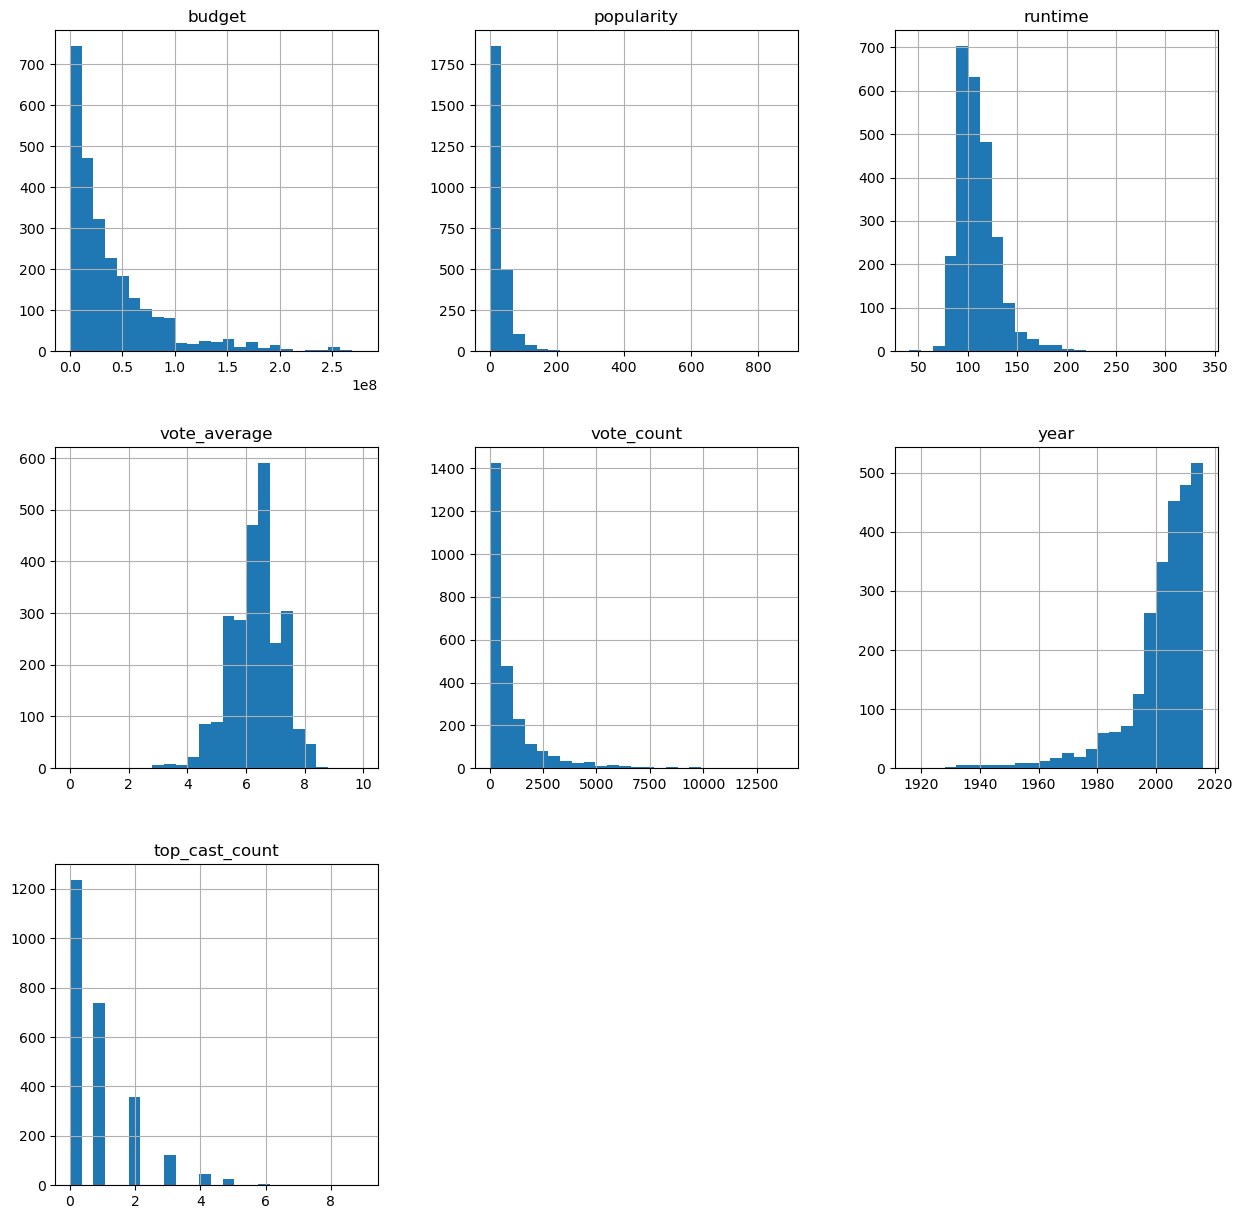

In [40]:
numeric = pd.concat([exploratory.select_dtypes(['int64', 'float64']), notional_to_numeric], axis=1)
numeric.hist(figsize=(15,15), bins=25)

In [41]:
numeric

,budget,popularity,runtime,vote_average,vote_count,year,top_cast_count
3643,5000000,10.095184,91.0,6.9,165,2010,1
3481,6000000,6.497285,104.0,6.9,113,2009,0
5,258000000,115.699814,139.0,5.9,3576,2007,5
3792,1300000,7.605291,102.0,6.7,27,1988,0
800,58000000,12.296030,125.0,5.9,178,2012,0
...,...,...,...,...,...,...,...
152,145000000,56.747978,95.0,6.7,1603,2016,4
1891,25000000,20.561682,121.0,6.9,483,2013,1
4585,400000,64.782984,91.0,7.8,1708,1975,0
4018,2500000,12.030456,98.0,5.0,229,1982,0


In [42]:
numeric.corr().style.background_gradient(cmap='RdYlGn')

,budget,popularity,runtime,vote_average,vote_count,year,top_cast_count
budget,1.000000,0.428162,0.252162,-0.025965,0.550360,0.250262,0.341296
popularity,0.428162,1.000000,0.186101,0.271775,0.734835,0.148924,0.207825
runtime,0.252162,0.186101,1.000000,0.358264,0.269504,-0.133285,0.125862
vote_average,-0.025965,0.271775,0.358264,1.000000,0.369436,-0.172740,0.071763
vote_count,0.550360,0.734835,0.269504,0.369436,1.000000,0.163250,0.276789
year,0.250262,0.148924,-0.133285,-0.172740,0.163250,1.000000,0.175090
top_cast_count,0.341296,0.207825,0.125862,0.071763,0.276789,0.175090,1.000000


<Axes: xlabel='popularity', ylabel='vote_count'>

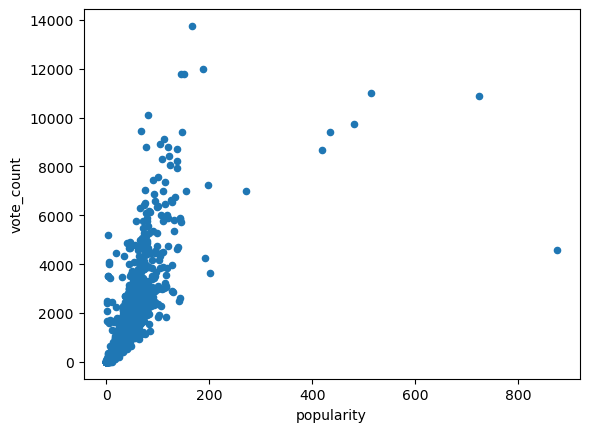

In [43]:
numeric.plot(kind='scatter', x='popularity', y='vote_count') # strongly correlated features

We had to take care of **heteroscedasticity**. Luckily log transformation took care of it. Now we have more or less the same variance of residuals across all values.
We also could notice some outliers. Let's take a look at observations with popularity higher than 400.

<Axes: xlabel='popularity', ylabel='vote_count'>

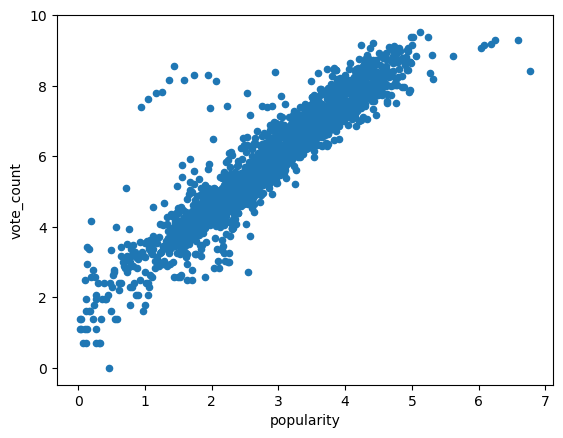

In [44]:
possible_outliers = exploratory[exploratory['popularity'] > 400]

numeric[['popularity', 'vote_count']] = np.log(exploratory[['popularity', 'vote_count']] + 1)
numeric.plot(kind='scatter', x='popularity', y='vote_count')

In [45]:
possible_outliers # huge blockbusters -> nothing to worry about then

,budget,genres,homepage,keywords,original_language,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,vote_average,vote_count,cast,crew
127,150000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.madmaxmovie.com/,"[{""id"": 2964, ""name"": ""future""}, {""id"": 3713, ...",en,434.278564,"[{""name"": ""Village Roadshow Pictures"", ""id"": 7...","[{""iso_3166_1"": ""AU"", ""name"": ""Australia""}, {""...",2015-05-13,120.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,7.2,9427,"[{""cast_id"": 2, ""character"": ""Max Rockatansky""...","[{""credit_id"": ""577da370c3a36817f8003838"", ""de..."
95,165000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 18, ""...",http://www.interstellarmovie.net/,"[{""id"": 83, ""name"": ""saving the world""}, {""id""...",en,724.247784,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...","[{""iso_3166_1"": ""CA"", ""name"": ""Canada""}, {""iso...",2014-11-05,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,8.1,10867,"[{""cast_id"": 9, ""character"": ""Joseph Cooper"", ...","[{""credit_id"": ""52fe4bbf9251416c910e4801"", ""de..."
28,150000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.jurassicworld.com/,"[{""id"": 1299, ""name"": ""monster""}, {""id"": 1718,...",en,418.708552,"[{""name"": ""Universal Studios"", ""id"": 13}, {""na...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2015-06-09,124.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,6.5,8662,"[{""cast_id"": 10, ""character"": ""Owen Grady"", ""c...","[{""credit_id"": ""52fe4bf7c3a368484e1a0683"", ""de..."
788,58000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.foxmovies.com/movies/deadpool,"[{""id"": 2095, ""name"": ""anti hero""}, {""id"": 307...",en,514.569956,"[{""name"": ""Twentieth Century Fox Film Corporat...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2016-02-09,108.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,7.4,10995,"[{""cast_id"": 99, ""character"": ""Wade Wilson / D...","[{""credit_id"": ""56c986b2925141172f0068b6"", ""de..."
94,170000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 878, ""na...",http://marvel.com/guardians,"[{""id"": 8828, ""name"": ""marvel comic""}, {""id"": ...",en,481.098624,"[{""name"": ""Marvel Studios"", ""id"": 420}, {""name...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2014-07-30,121.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,7.9,9742,"[{""cast_id"": 1, ""character"": ""Peter Quill / St...","[{""credit_id"": ""538ce329c3a3687155003358"", ""de..."
546,74000000,"[{""id"": 10751, ""name"": ""Family""}, {""id"": 16, ""...",http://www.minionsmovie.com/,"[{""id"": 3487, ""name"": ""assistant""}, {""id"": 179...",en,875.581305,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""n...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2015-06-17,91.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,6.4,4571,"[{""cast_id"": 22, ""character"": ""Scarlet Overkil...","[{""credit_id"": ""5431b2b10e0a2656e20026c7"", ""de..."


In [46]:
numeric.corr().style.background_gradient(cmap='coolwarm')

,budget,popularity,runtime,vote_average,vote_count,year,top_cast_count
budget,1.000000,0.483707,0.252162,-0.025965,0.505146,0.250262,0.341296
popularity,0.483707,1.000000,0.193693,0.336431,0.931195,0.218693,0.297729
runtime,0.252162,0.193693,1.000000,0.358264,0.199772,-0.133285,0.125862
vote_average,-0.025965,0.336431,0.358264,1.000000,0.370480,-0.172740,0.071763
vote_count,0.505146,0.931195,0.199772,0.370480,1.000000,0.234498,0.321730
year,0.250262,0.218693,-0.133285,-0.172740,0.234498,1.000000,0.175090
top_cast_count,0.341296,0.297729,0.125862,0.071763,0.321730,0.175090,1.000000


In [47]:
feature_mean = make_pipeline(FeatureSelector(['vote_count', 'popularity']), MeanTransformer('popularity_vote')).fit_transform(exploratory)
feature_mean.head()

,popularity_vote
3643,87.547592
3481,59.748643
5,1845.849907
3792,17.302646
800,95.148015


In [48]:
numeric['vote_popularity'] = feature_mean
numeric.drop(columns=['popularity', 'vote_count'], inplace=True)

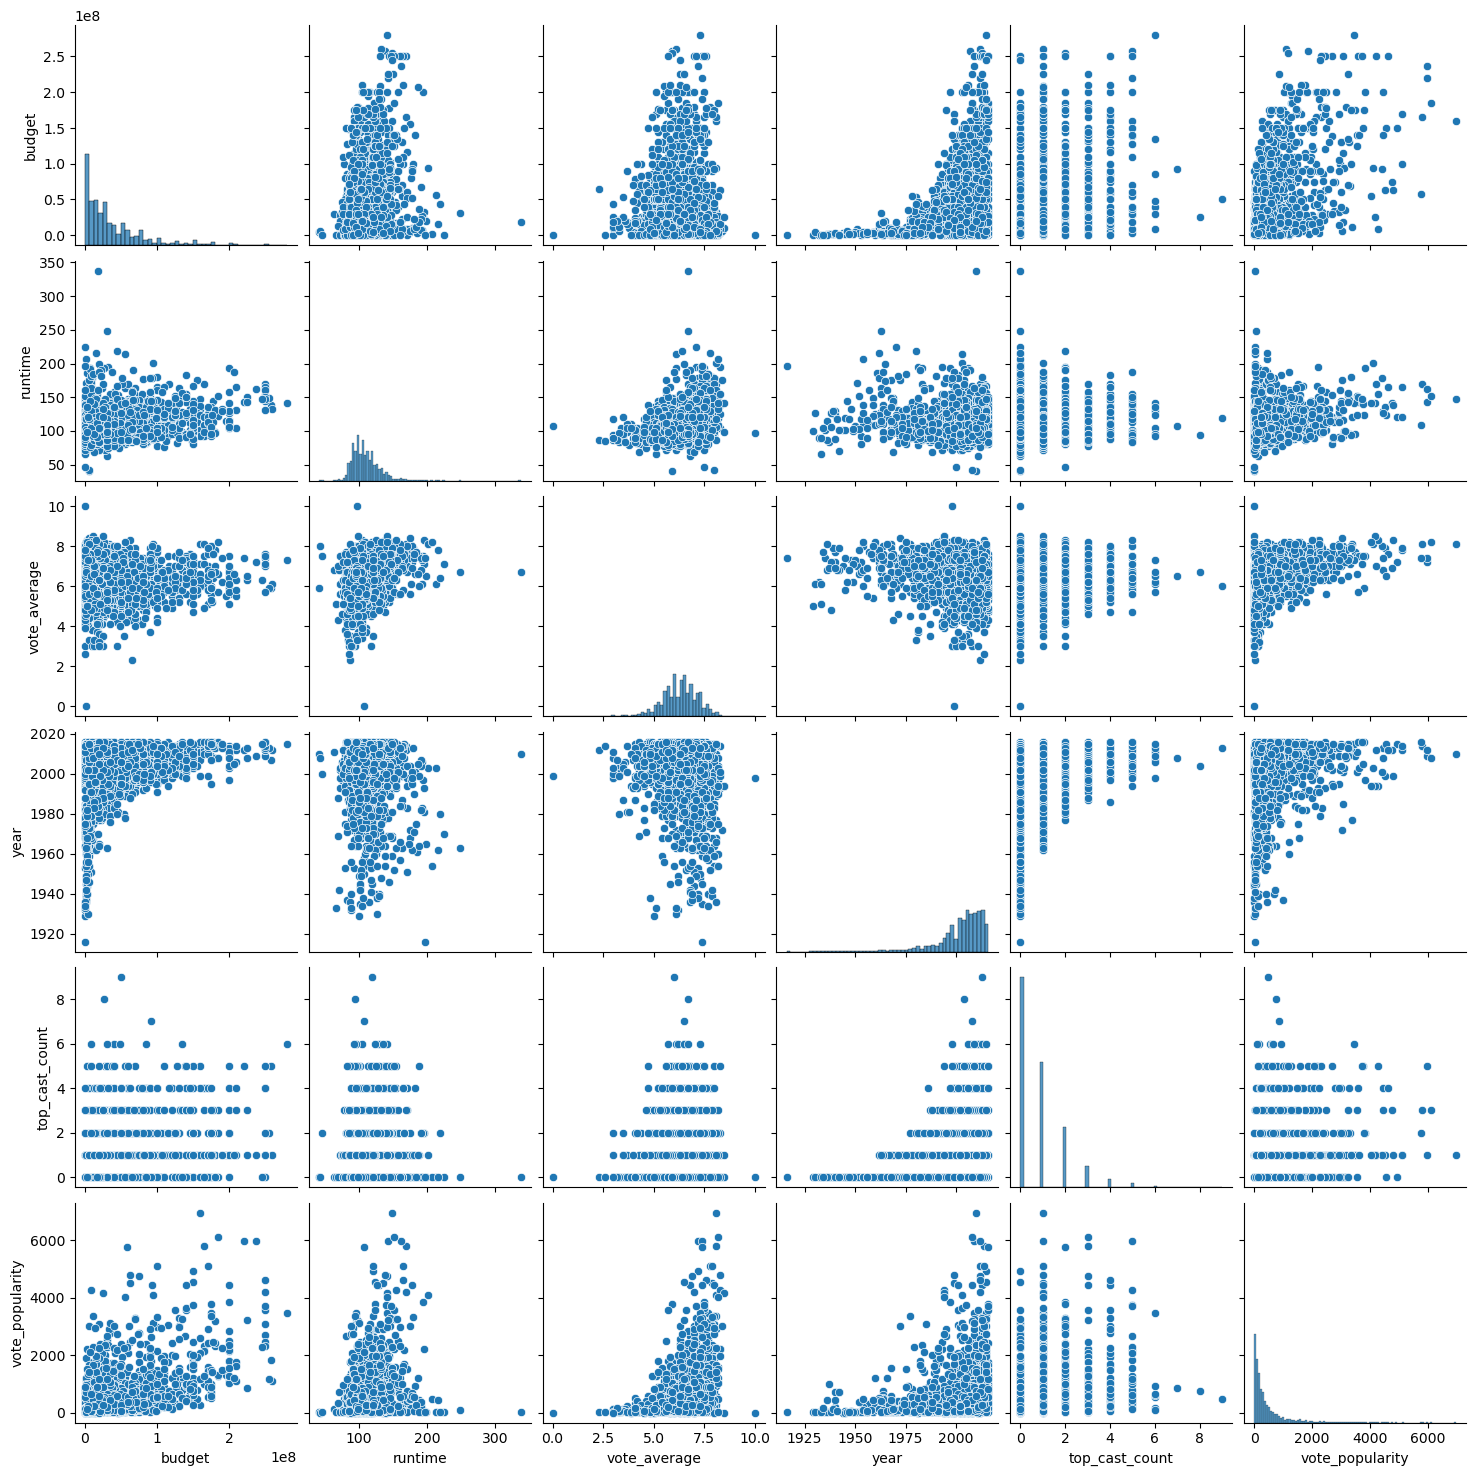

In [49]:
sns.pairplot(numeric)

R2 score - coefficient of determination:
Measures the proportion of the variance of the dependent variable explained by the independent variables in a regression model: 
$$R^{2}:={\frac {\sum \limits _{i=1}^{n}({\hat {y}}_{i}-{\overline {y}})^{2}}{\sum \limits _{i=1}^{n}(y_{i}-{\overline {y}})^{2}}}$$

Logically - the variance of the estimate against the mean divided by the actual variance against the mean. We check to what extent the model fits the data better than the mean:  $R^2 = \frac{{\text{Var}(\mathbf{\bar{y}}) - \text{Var}(\mathbf{\hat{y}})}}{{\text{Var}(\mathbf{\bar{y}})}}$
: there is n% less variance between the model output (e.g. a line) and the actual points than between the average and the actual points

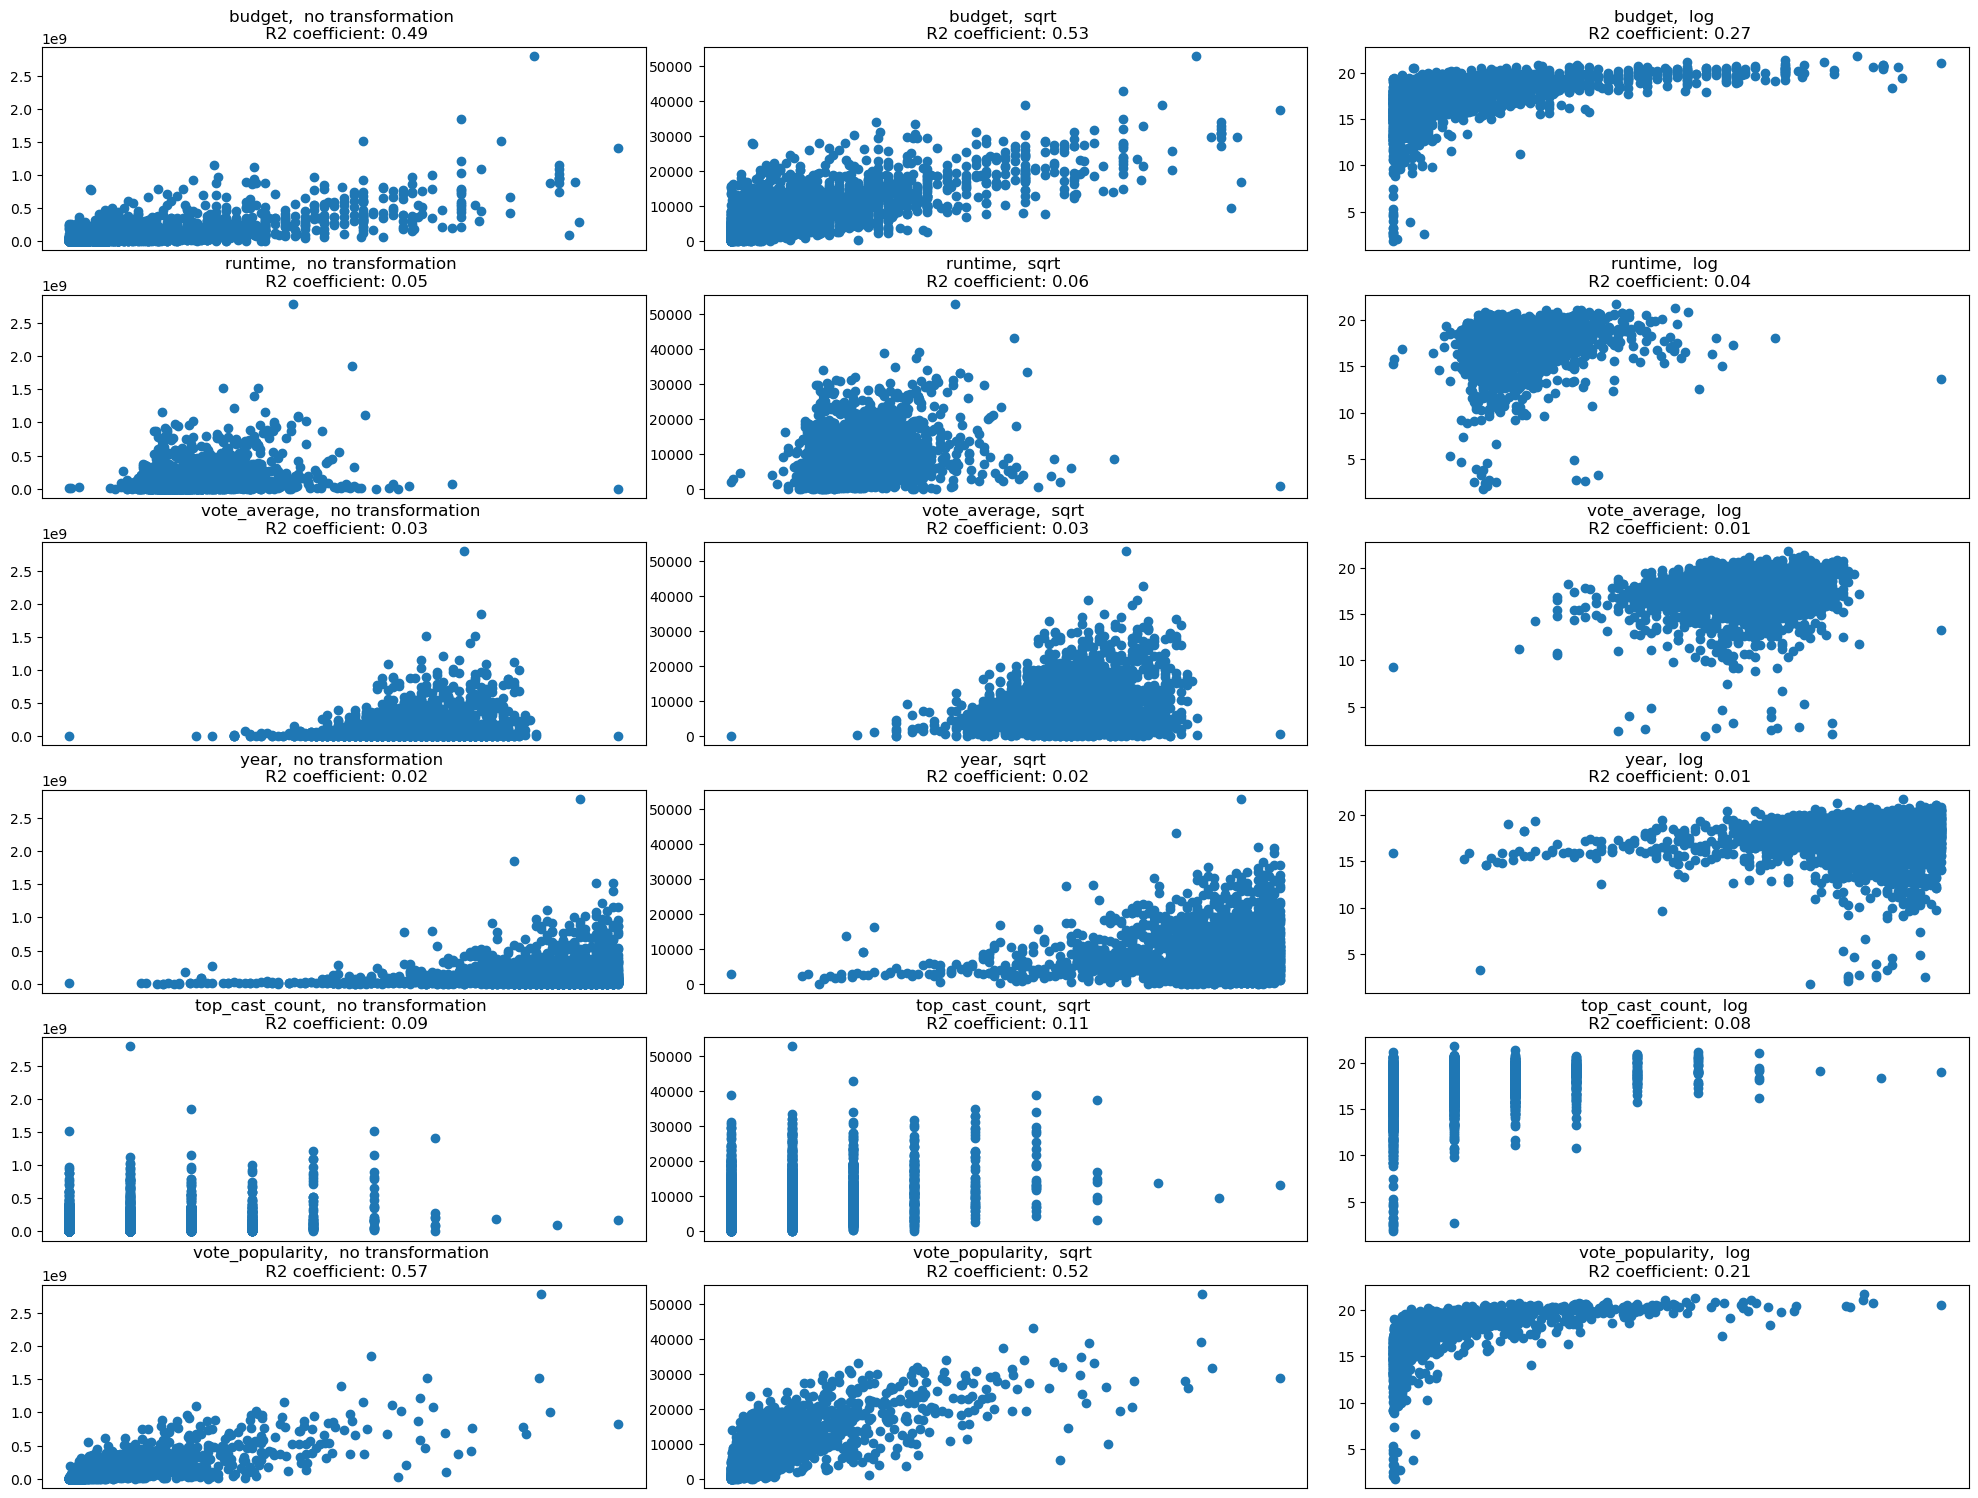

In [50]:
from scipy.stats import pearsonr

transformations = [lambda x: x, np.sqrt, lambda x: np.log(x+1)]
tran_description = [' no transformation', ' sqrt', ' log']
numeric_columns = numeric.columns

fig, axes = plt.subplots(len(numeric_columns), len(transformations), figsize=(20,15))
fig.tight_layout()

for col_idx, col in enumerate(numeric_columns):
    for tran_idx, tran in enumerate(transformations):
        axes[col_idx, tran_idx].scatter(x=numeric[col], y=tran(y_train))
        axes[col_idx, tran_idx].set_xticklabels([])
        axes[col_idx, tran_idx].set_xticks([]) 
        R2 = pearsonr(numeric[col], tran(y_train))[0]**2     
        axes[col_idx, tran_idx].title.set_text(f'{col}, {tran_description[tran_idx]} \n R2 coefficient: {R2:.2f}')
               
plt.show()

# 2. Building a pipeline

In [51]:
union = make_union(
    make_pipeline(
        FeatureSelector('genres'),
        DictionaryVectorizer('name')
    ),
    make_pipeline(
        FeatureSelector('homepage'),
        Binarizer(lambda x: isinstance(x, float), 'missing_homepage')
    ),
    make_pipeline(
        FeatureSelector('keywords'),
        DictionaryVectorizer('name'),
        TopFeatures(0.5)
    ),
    make_pipeline(
        FeatureSelector('original_language'),
        Binarizer(lambda x: x == 'en', 'en')
    ),
    make_pipeline(
        FeatureSelector('production_companies'),
        DictionaryVectorizer('name'),
        TopFeatures(1)
    ),
    make_pipeline(
        FeatureSelector('production_countries'),
        DictionaryVectorizer('name'),
        TopFeatures(25)
    ),
    make_pipeline(
        FeatureSelector('release_date'),
        DateTransformer()
    ),
    make_pipeline(
        FeatureSelector('spoken_languages'),
        ItemCounter(),
        Binarizer(lambda x: x > 1, 'multilingual')
    ),
    make_pipeline(
        FeatureSelector('original_language'),
        Binarizer(lambda x: x == 'Released', 'Released')
    ),    
    make_pipeline(
        FeatureSelector('cast'),
        DictionaryVectorizer('name'),
        TopFeatures(0.25),
        SumTransformer('top_cast_count')
    ),
    make_pipeline(
        FeatureSelector('crew'),
        DictionaryVectorizer('name', False),
        TopFeatures(1)
    ),
    make_pipeline(
        FeatureSelector(['budget', 'runtime', 'vote_average'])
    ),
    make_pipeline(
        FeatureSelector(['popularity', 'vote_count']),
        MeanTransformer('popularity_vote')
    )
)

In [52]:
# using it without union: pd.concat((df, pipe.fit_transform(df)) ,axis=1) ...

In [53]:
%%time
union.fit(X_train)
print('Fitted')

Fitted
CPU times: user 8.79 s, sys: 146 ms, total: 8.94 s
Wall time: 8.96 s


In [54]:
%%time
X_train_T = union.transform(X_train)
X_test_T = union.transform(X_test)

print(X_train_T.shape)
print(X_test_T.shape)

(2534, 144)
(845, 144)
CPU times: user 3.85 s, sys: 110 ms, total: 3.96 s
Wall time: 3.96 s


In [55]:
# little post processing
X_train_T = handle_same_name_col(X_train_T)
X_test_T = handle_same_name_col(X_test_T)

Duplicate found
Duplicate found


In [56]:
X_train_T.columns.duplicated().sum()

0

In [57]:
# sns.histplot(X_test_T.budget, kde=True)

In [58]:
# TODO: based on features distribution scale it with proper scalers
# E.g:
# Normalize : if data data doesn't have Gaussian distribution
# Standardize : if data have Gaussian distribution

In [59]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
scaler = Scaler(columns=['budget'], scaler=StandardScaler())
X_train_S = scaler.fit_transform(X_train_T)
X_test_S = scaler.transform(X_test_T)

In [60]:
# sns.histplot(X_test_S.budget, kde=True)

# 3. Building regressor

In [65]:
%%time
from predictors import stacking_model_pipe

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# TODO: try some regularization
#reg_lambda, reg_alpha
#lambda_l1, lambda_l2

params = {
    'n_estimators': np.linspace(10, 1000, 10).astype(int),
    'learning_rate': np.linspace(0.01, 0.1, 10),
}

regressors = [XGBRegressor(verbosity=0), LGBMRegressor(verbose=-1), CatBoostRegressor(verbose=0)]
param_list = [params, params, params]

ensemble, weak_learners = stacking_model_pipe(X=X_train_T,
                                   y=y_train,
                                   models=regressors,
                                   params=param_list,
                                   final_estimator=MLPRegressor())

y_hat = ensemble.predict(X_test_T)
ensemble_mse = np.sqrt(mean_squared_error(y_hat, y_test))
ensemble_r2 = r2_score(y_hat, y_test)
ensemble_r2, ensemble_mse

CPU times: user 1h 12min 7s, sys: 2min 7s, total: 1h 14min 14s
Wall time: 7min 44s


(0.7220988946689139, 84055176.7692111)

In [62]:
# reg = cv_model(cv=10, rand=True, regressor=LGBMRegressor(verbose=-1), params=params)
# reg.fit(X_train_T, y_train)
# y_h = reg.predict(X_test_T)
# r2_score(y_hat, y_test), mean_absolute_error(y_hat, y_test)

In [63]:
# for the same split better hpo resulted in
# (0.7164131197388182, 47136637.68366897) -> (0.7493620844507618, 46235385.97408483)

In [66]:
# sanity check
for i, model in enumerate(weak_learners):
    y_hat_weak = model[1].predict(X_test_T)
    mae = np.sqrt(mean_squared_error(y_hat_weak, y_test))
    if mae < ensemble_mse:
        print(f'Weak learner {i} is better than ensemble')

Weak learner 2 is better than ensemble


In [72]:
y_hat1 = weak_learners[2][1].predict(X_test_T)
r2_score(y_hat1, y_test), np.sqrt(mean_squared_error(y_hat1, y_test))

(0.7067444719827405, 83960113.44514258)

In [75]:
feature_importances = [weak_learners[2][1].feature_importances_ for model in weak_learners]
feature_importances = pd.DataFrame(feature_importances, columns=X_train_T.columns)
feature_importances

,action,adventure,animation,comedy,crime,documentary,drama,family,fantasy,foreign,history,horror,music,mystery,romance,science_fiction,thriller,war,western,missing_homepage,duringcreditsstinger,woman_director,based_on_novel,independent_film,murder,aftercreditsstinger,dystopia,violence,revenge,sport,3d,sequel,los_angeles,friendship,biography,teenager,new_york,alien,police,love,superhero,musical,suspense,sex,prison,london_england,drug,family_47,based_on_comic_book,high_school,dying_and_death,magic,nudity,father_son_relationship,daughter,corruption,remake,en,warner_bros_,universal_pictures,paramount_pictures,twentieth_century_fox_film_corporation,columbia_pictures,new_line_cinema,touchstone_pictures,walt_disney_pictures,relativity_media,metro_goldwyn_mayer__mgm_,columbia_pictures_corporation,village_roadshow_pictures,miramax_films,dreamworks_skg,regency_enterprises,united_artists,dune_entertainment,canal_,fox_searchlight_pictures,fox_2000_pictures,tristar_pictures,lionsgate,working_title_films,amblin_entertainment,summit_entertainment,dimension_films,the_weinstein_company,studiocanal,legendary_pictures,spyglass_entertainment,united_states_of_america,united_kingdom,germany,france,canada,australia,spain,japan,italy,china,hong_kong,ireland,india,new_zealand,year,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Fri,Mon,Sat,Sun,Thu,Tue,Wed,month_sin,month_cos,day_sin,day_cos,multilingual,Released,top_cast_count,robert_rodriguez,steven_spielberg,mary_vernieu,avy_kaufman,james_newton_howard,hans_zimmer,harvey_weinstein,deborah_aquila,bob_weinstein,francine_maisler,john_williams,budget,runtime,vote_average,popularity_vote
0,0.306671,0.755826,1.166705,0.089742,0.429254,0.0,0.220058,2.416981,0.643351,0.0,0.004228,0.0,0.037512,0.018143,0.400789,0.730543,0.108227,0.003538,0.122702,0.56603,0.23208,0.066074,0.132072,0.010903,0.077649,0.064637,0.619873,0.008365,0.009048,0.0,2.1876,0.31364,0.061482,0.0,0.0,0.01629,0.02031,0.21114,0.000989,0.0,0.160051,0.012009,0.025264,0.0,0.009638,0.008989,0.013281,0.031498,0.22746,0.015898,0.047327,0.02484,0.014674,0.090072,0.028909,0.0209,0.026828,0.002375,0.085471,0.19854,0.185456,0.975878,0.002497,0.093437,0.010734,0.133042,0.059376,0.0,0.0,0.038332,0.0,0.035308,0.008111,0.00887,0.063,0.000484,0.000175,0.040692,0.013912,0.008458,0.004567,0.157057,0.242473,0.0,0.004064,0.002315,0.033744,0.029748,0.052106,0.190195,0.028091,0.036427,0.001034,0.028308,0.003787,0.00134,0.000842,0.021696,0.0431,0.0,0.0,0.027375,3.636301,0.020281,0.009675,0.129785,0.025311,0.0,0.27433,0.24348,0.015282,0.438384,0.012018,0.027413,0.004763,0.289798,0.074556,0.004694,0.019562,0.077362,0.020245,0.180106,1.138687,2.198852,0.427796,0.525183,0.482609,0.0,1.179343,0.01094,0.392283,0.00537,0.028197,0.220743,0.138203,0.004239,0.044997,0.000927,0.072736,0.734288,25.172611,3.730905,3.474051,38.831185
1,0.306671,0.755826,1.166705,0.089742,0.429254,0.0,0.220058,2.416981,0.643351,0.0,0.004228,0.0,0.037512,0.018143,0.400789,0.730543,0.108227,0.003538,0.122702,0.56603,0.23208,0.066074,0.132072,0.010903,0.077649,0.064637,0.619873,0.008365,0.009048,0.0,2.1876,0.31364,0.061482,0.0,0.0,0.01629,0.02031,0.21114,0.000989,0.0,0.160051,0.012009,0.025264,0.0,0.009638,0.008989,0.013281,0.031498,0.22746,0.015898,0.047327,0.02484,0.014674,0.090072,0.028909,0.0209,0.026828,0.002375,0.085471,0.19854,0.185456,0.975878,0.002497,0.093437,0.010734,0.133042,0.059376,0.0,0.0,0.038332,0.0,0.035308,0.008111,0.00887,0.063,0.000484,0.000175,0.040692,0.013912,0.008458,0.004567,0.157057,0.242473,0.0,0.004064,0.002315,0.033744,0.029748,0.052106,0.190195,0.028091,0.036427,0.001034,0.028308,0.003787,0.00134,0.000842,0.021696,0.0431,0.0,0.0,0.027375,3.636301,0.020281,0.009675,0.129785,0.025311,0.0,0.27433,0.24348,0.015282,0.438384,0.012018,0.027413,0.004763,0.289798,0.074556,0.004694,0.019562,0.077362,0.020245,0.180106,1.138687,2.198852,0.427796,0.525183,0.482609,0.0,1.179343,0.01094,0.392283,0.00537,0.028197,0.220743,0.138203,0.004239,0.044997,0.000927,0.072736,0.734288,25.17261

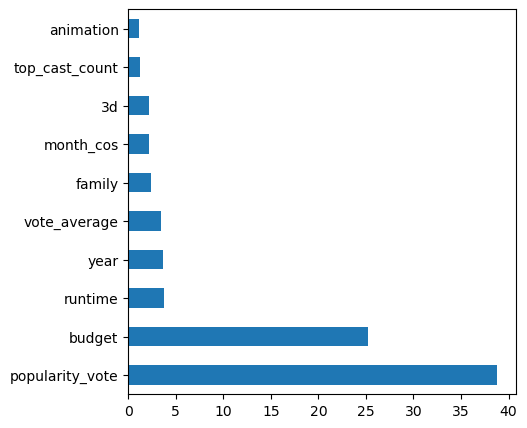

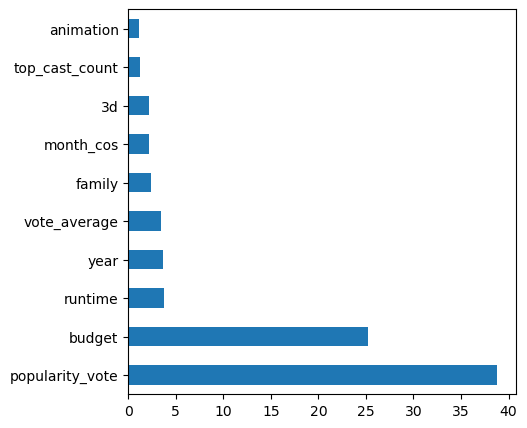

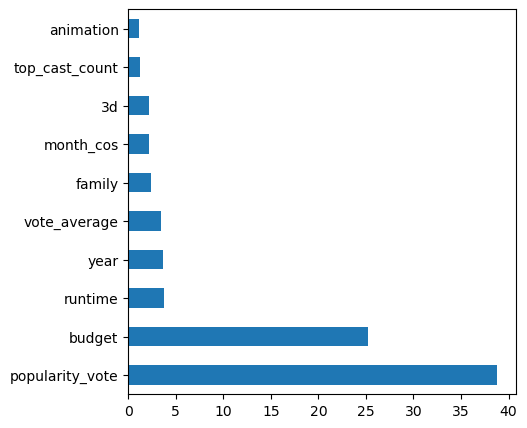

In [76]:
plot_weak_learners_feature_importance(feature_importances)

### Retrain for best features experiment
Interesting approach but that might lead to overfitting

In [ ]:
X_train_best_disj, X_test_best_disj = data_with_important_features(X_train_T, X_test_T, feature_importances, conjunction=False)
ensemble, weak_learners = stacking_model_pipe(X_train_best_disj,
                                   y_train,
                                   regressors,
                                   param_list,
                                   MLPRegressor())

y_hat_disj = ensemble.predict(X_test_best_disj)
r2_score(y_hat_disj, y_test), np.sqrt(mean_squared_error(y_hat_disj, y_test))

In [ ]:
X_train_best_conj, X_test_best_conj = data_with_important_features(X_train_T, X_test_T, feature_importances, conjunction=True)
ensemble, weak_learners = stacking_model_pipe(X_train_best_conj,
                                   y_train,
                                   regressors,
                                   param_list,
                                   MLPRegressor())
y_hat_conj = ensemble.predict(X_test_best_conj)
r2_score(y_hat_conj, y_test), np.sqrt(mean_squared_error(y_hat_conj, y_test))

In [ ]:
# drop unused features method.

In [ ]:
# disjunction looks better?

In [ ]:
# TODO:
# feature selection transformer - based on dtype - stat test, correlation, variance thshr

In [71]:
# import matplotlib.pyplot as plt
# N = 30
# x = np.arange(y_hat.shape[0])[:N]
# plt.figure(figsize=(10,10))
# plt.plot(x, y_hat[:N], label='prediction')
# plt.plot(x, y_test[:N], label='truth')
# plt.xticks(visible=False)
# plt.legend()
# plt.show()